In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [95]:
!pip install -U scikit-learn

In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [97]:
!wget -nc https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv

File ‘perrin-freres-monthly-champagne.csv’ already there; not retrieving.



In [98]:
df = pd.read_csv(
  'perrin-freres-monthly-champagne.csv',
  index_col='Month',
  engine='python',
  parse_dates=True)

In [99]:
df.columns = ['Sales']

In [100]:
df = df.iloc[:-2] # dropping last 2 rows from data frame because last 2 entries of Sales data is NAN

In [101]:
df['LogSales'] = np.log(df['Sales'])
'''
This BOX-COX transformation with lambda = 0
Purpose of BOX-COX transformation: To make a dataset more closely resemble a normal distribution, which is a common assumption for
many statistical tests and models. This helps stabilize variance and can lead to better model performance.
'''

'\nThis BOX-COX transformation with lambda = 0\nPurpose of BOX-COX transformation: To make a dataset more closely resemble a normal distribution, which is a common assumption for \nmany statistical tests and models. This helps stabilize variance and can lead to better model performance.\n'

In [102]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [103]:
# Make supervised dataset
# let's see if we can use T past values to predict the next value

series = df['LogSales'].to_numpy()

T = 12
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (93, 12) Y.shape (93,)


In [104]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [105]:
Xtest.shape

(12, 12)

In [106]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtrain, Ytrain)

0.8682372095558999

In [107]:
lr.score(Xtest, Ytest)

0.9657520752272787

In [108]:
# Boolean index
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T] = False # first T values are not predictable

In [109]:
# 1-step forecast
df.loc[train_idx, 'LR_1step_train'] = lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = lr.predict(Xtest)

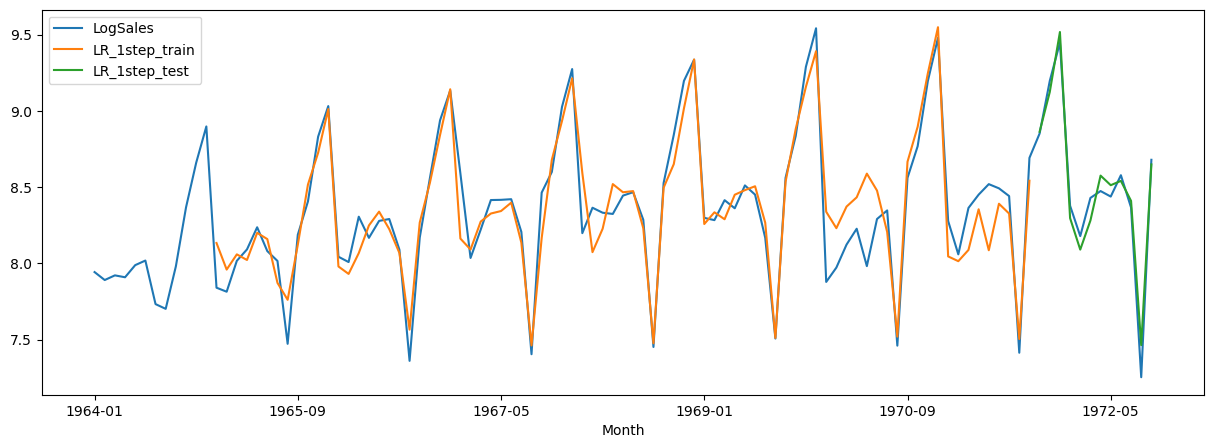

In [110]:
# plot 1-step forecast
df[['LogSales', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(15, 5));

In [111]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = lr.predict(last_x.reshape(1, -1))[0]

  # update the predictions list
  multistep_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [112]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'LR_multistep'] = multistep_predictions

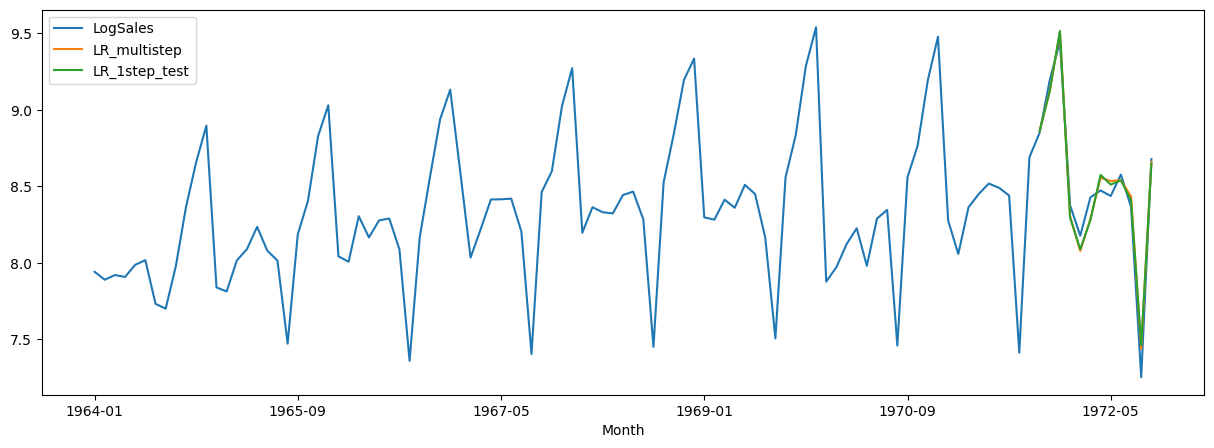

In [113]:
# plot 1-step and multi-step forecast
df[['LogSales', 'LR_multistep', 'LR_1step_test']].plot(figsize=(15, 5));

In [114]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (82, 12) Y.shape (82, 12)


In [115]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:] # test data is only one row

In [118]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

0.8829262390390559

In [119]:
r2_score(Ytest_m.flatten(), lr.predict(Xtest_m).flatten())

0.9626860771231436

In [120]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'LR_multioutput'] = lr.predict(Xtest_m).flatten()

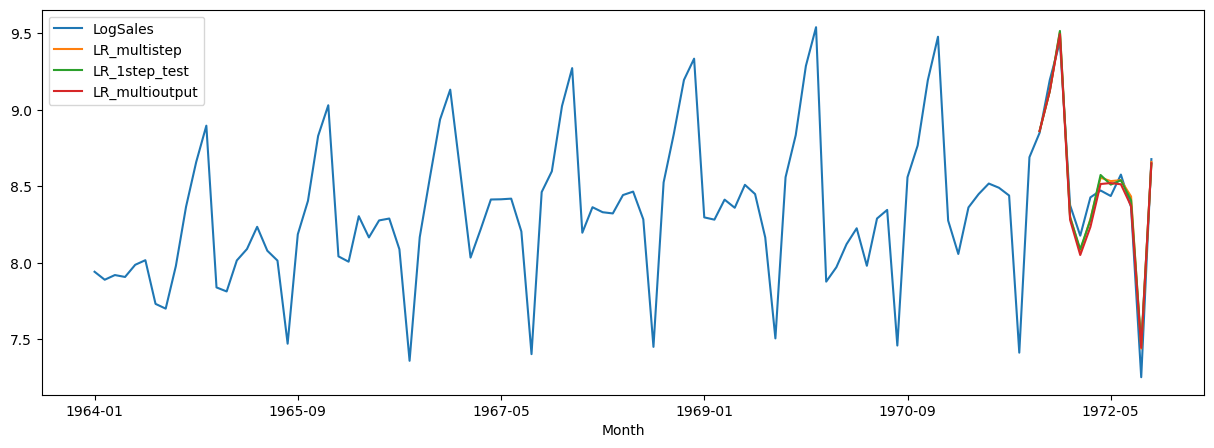

In [121]:
# plot all forecasts
cols = ['LogSales', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df[cols].plot(figsize=(15, 5));

In [123]:
# MAPE
mape0 = mean_absolute_percentage_error(Ytest, df.loc[test_idx, 'LR_1step_test'])
print("1step MAPE:", mape0)
mape1 = mean_absolute_percentage_error(Ytest, multistep_predictions)
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    Ytest, df.loc[test_idx, 'LR_multioutput'])
print("multi-output MAPE:", mape2)

1step MAPE: 0.009784167557640831
multi-step MAPE: 0.009607169373797667
multi-output MAPE: 0.009727020853255903


In [ ]:
# Test Other Models

In [124]:
def one_step_and_multistep_forecast(model, name):
  model.fit(Xtrain, Ytrain)
  print("One-step forecast:", name)
  # print("Train R^2:", model.score(Xtrain, Ytrain))
  # print("Test R^2 (1-step):", model.score(Xtest, Ytest))

  # store 1-step forecast
  df.loc[train_idx, f'{name}_1step_train'] = model.predict(Xtrain)
  df.loc[test_idx, f'{name}_1step_test'] = model.predict(Xtest)

  # generate multi-step forecast
  multistep_predictions = []

  # first test input
  last_x = Xtest[0]

  while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1))[0]

    # update the predictions list
    multistep_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

  # store multi-step forecast
  df.loc[test_idx, f'{name}_multistep_test'] = multistep_predictions

  # MAPE of multi-step forecast
  mape = mean_absolute_percentage_error(Ytest, multistep_predictions)
  print("Test MAPE (multi-step):", mape)

  # plot 1-step and multi-step forecast
  cols = [
    'LogSales',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test'
  ]
  df[cols].plot(figsize=(15, 5));

One-step forecast: SVR
Test MAPE (multi-step): 0.013188370472848127


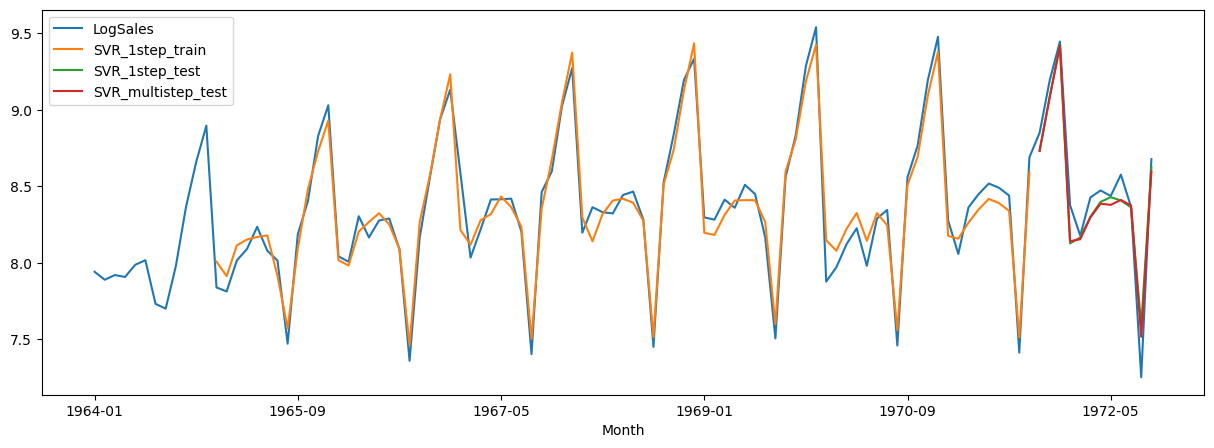

In [125]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step forecast: RF
Test MAPE (multi-step): 0.012036252954611934


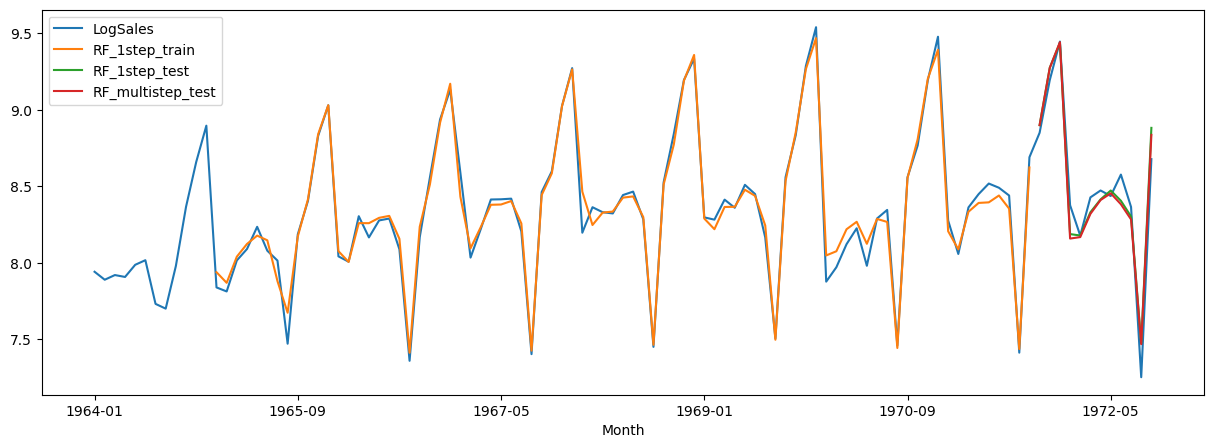

In [126]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

In [127]:
def multi_output_forecast(model, name):
  model.fit(Xtrain_m, Ytrain_m)

  # save multi-output forecast to dataframe
  df.loc[test_idx, f'{name}_multioutput'] = model.predict(Xtest_m).flatten()

  mape = mean_absolute_percentage_error(
      Ytest, df.loc[test_idx, f'{name}_multioutput'])
  print("Test MAPE (multi-output):", mape)

  # plot all forecasts
  # assume that previous functions have been run
  cols = [
    'LogSales',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test',
    f'{name}_multioutput',
  ]
  df[cols].plot(figsize=(15, 5));

In [ ]:
# multi_output_forecast(SVR(), "SVR") # cannot handle multi-output!
'''
Therefore below we create a SVR wrapper. The SVR wrapper creates ONE SEPARATE SUPPORT VECTOR MACHINE for EACH COLUMN OF Ytrain_m/Ytest_m
So, a total of Ntest SUPPORT VECTOR MACHINES are created.
'''

In [128]:
class SVRWrapper:
  def __init__(self, h, **args):
    self.h = h
    self.models = [SVR(**args) for _ in range(h)]

  def fit(self, X, Y):
    for k in range(self.h):
      self.models[k].fit(X, Y[:, k])

  def predict(self, X):
    P = [m.predict(X) for m in self.models]
    return np.hstack(P)

Test MAPE (multi-output): 0.014398830617948374


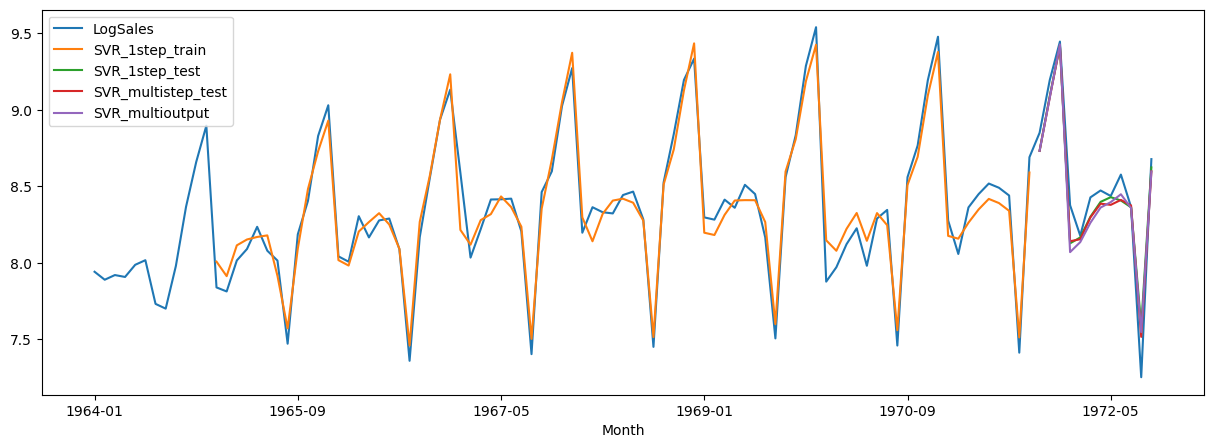

In [129]:
multi_output_forecast(SVRWrapper(Ntest), "SVR")

Test MAPE (multi-output): 0.019796678703759316


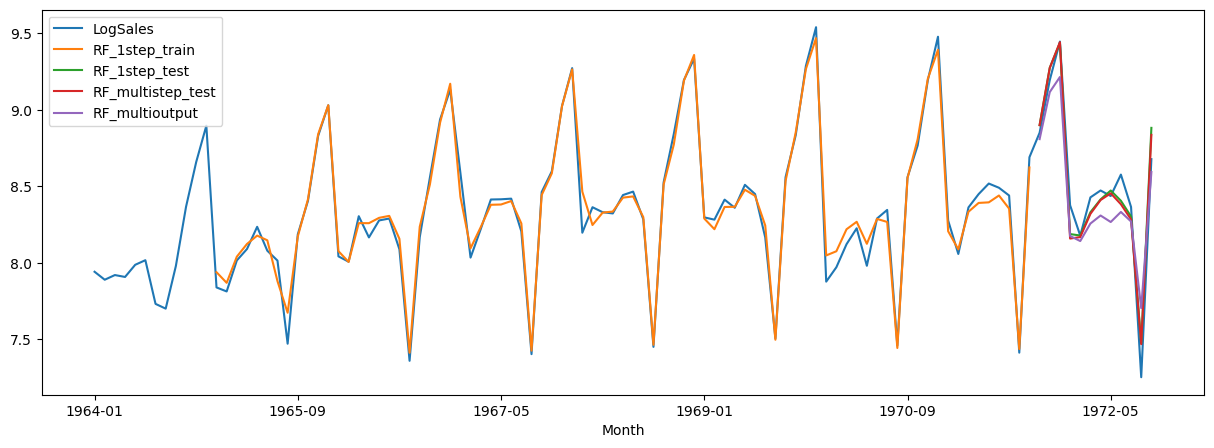

In [130]:
multi_output_forecast(RandomForestRegressor(), "RF")

In [ ]:
# Exercise: compute MAPE for non-logged data (i.e. exponentiate predictions)
# Compare with previous models (e.g. ARIMA, ETS)

# Exercise: does differencing help?